<a href="https://colab.research.google.com/github/erlichsefi/ScrapeAnything/blob/main/browser_base_translation%20/%20JavaScript%20Converting%20Robust%20Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting sites to dataframe

# first: install selenium & chromium

In [1]:
# According to: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
%%capture
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium
apt install chromium-chromedriver
pip install pandas

In [2]:
script_with_logs = """
// Get all elements in the HTML page
const elements = document.getElementsByTagName('*');

// Create an array to store the element details
const elementDetails = [];

// Iterate through each element
for (let i = 0; i < elements.length; i++) {
  const element = elements[i];

  // Get the bounding rectangle of the element
  const rect = element.getBoundingClientRect();

  // Get the text content of the element
  const textContent = element.hasAttribute('textContent') ? element.getAttribute('textContent').trim() : '';

  // Get the tooltip value if it exists
  const tooltip = element.hasAttribute('title') ? element.getAttribute('title') : '';

  // Store the element, its bounding rectangle, text content, and tooltip details
  const elementInfo = {
    element: element,
    rect: rect,
    textContent: textContent.replaceAll(",",";"),
    ariaLabel: (element.hasAttribute('aria-label') ? element.getAttribute('aria-label') : '').replaceAll(",",";"),
    tooltip: tooltip.replaceAll(",",";"),
    e_type: (element.hasAttribute('nodeName') ? element.getAttribute('nodeName') : '').replaceAll(",",";"),
    data_initial_value: (element.hasAttribute('data-initial-value') ? element.getAttribute('data-initial-value') : '').replaceAll(",",";"),
  };
  if (typeof elementInfo.rect !== 'undefined' && elementInfo.rect.width > 0 && elementInfo.rect.height > 0){
  // Add the element details to the array
   if (elementInfo.tooltip != '' || elementInfo.textContent != '' || elementInfo.ariaLabel != ''){
    elementDetails.push(elementInfo);
    }
  }
}

let parents = elementDetails.map(e=>e.element.parentElement);
let withoutParents = elementDetails.filter(elementDetail=> !parents.includes(elementDetail.element));

// Display the element details
console.log("X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value");
console.log(withoutParents.map( e=> e.rect.x+","+e.rect.y+","+e.rect.width+","+e.rect.height+","+e.e_type+","+e.textContent+","+e.tooltip+","+e.ariaLabel+","+e.data_initial_value).join("\\n"));
"""

In [3]:
def write_to_text(filename,logs,error):
  with open(filename, 'w') as f:
    f.write(f"error={error}\n")
    f.write('\n'.join(logs))

In [4]:
def web_driver_to_image(wd,prefix=""):
  import re
  import os
  from urllib.parse import urlparse, urlunparse

  url = wd.current_url
  # Parse the URL
  parsed_url = urlparse(url)

  # Remove the query parameters
  clean_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, "", "", ""))
  file_name = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_url)
  file_name = f"{prefix}{file_name}"

  wd.save_screenshot(f"{file_name}.png")
  return file_name

def get_browser():
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service

    # restart the browser
    service = Service(executable_path=r'/usr/bin/chromedriver')
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless=new')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.headless = True
    wd = webdriver.Chrome(service=service,options=chrome_options)

    return wd

def screen_to_table(wd,url,raw=False):

  import pandas as pd
  import io

  for timeout in range(10,60,20):
    try:
      wd.set_page_load_timeout(timeout)
      wd.implicitly_wait(timeout)  # Set a timeout of 10 seconds
      wd.get(url)
      break

    except Exception:
      pass

  file_name = web_driver_to_image(wd)

  script = f"""
  var consoleLogs = [];
  var originalLog = console.log;
  console.log = function(message) {{
      consoleLogs.push(message);
      originalLog.apply(console, arguments);
  }};

  {script_with_logs}

  return consoleLogs;
  """

  logs = wd.execute_script(script)

  if not raw:
    df = pd.read_csv(io.StringIO("\n".join(logs)), sep=",")
  else:
    df = logs
  #wd.close()
  return file_name,df

In [5]:
news_sites = [
    "https://www.n12.co.il/",
    "https://www.cnn.com",
    "https://www.bbc.co.uk/news",
    "https://www.nytimes.com",
    "https://www.aljazeera.com",
    "https://www.reuters.com",
    "https://www.theguardian.com",
    "https://www.foxnews.com",
    "https://www.nbcnews.com",
    "https://www.bloomberg.com",
    "https://apnews.com",
    "https://www.huffpost.com",
    "https://www.usatoday.com",
    "https://www.washingtonpost.com",
    "https://www.wsj.com",
    "https://abcnews.go.com",
    "https://www.buzzfeednews.com",
    "https://www.cbsnews.com",
    "https://www.npr.org",
    "https://www.ft.com",
    "https://www.independent.co.uk",
]

In [6]:
wd = get_browser()

for url in news_sites:
  print(f" ---- URL = {url} ---- ")

  try:
    file_name,df = screen_to_table(wd,url)
    csv_file_name = f"{file_name}.csv"
    screenshot_file_name = f"{file_name}.png"
    df.to_csv(csv_file_name)

    print(f"screenshot_file_name = {screenshot_file_name}.")
    print(f"Parsing was sucsessful, csv_file_name = {csv_file_name}.")
  except Exception as e:
    file_name,df = screen_to_table(wd,url,raw=True)
    txt_file_name = f"{file_name}.txt"
    write_to_text(txt_file_name,df,e)


    print(f"screenshot_file_name = {screenshot_file_name}.")
    print(f"Parsing was un-sucsessful, txt_file_name = {txt_file_name}.")

  print(f"please make sure all text in screenshot is explained by output file")

<ipython-input-4-e5572476d542>:27: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


 ---- URL = https://www.n12.co.il/ ---- 
screenshot_file_name = https___www_n12_co_il_.png.
Parsing was sucsessful, csv_file_name = https___www_n12_co_il_.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.cnn.com ---- 
screenshot_file_name = https___www_cnn_com_.png.
Parsing was sucsessful, csv_file_name = https___www_cnn_com_.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.bbc.co.uk/news ---- 
screenshot_file_name = https___www_bbc_com_news.png.
Parsing was sucsessful, csv_file_name = https___www_bbc_com_news.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.nytimes.com ---- 
screenshot_file_name = https___www_nytimes_com_.png.
Parsing was sucsessful, csv_file_name = https___www_nytimes_com_.csv.
please make sure all text in screenshot is explained by output file
 ---- URL = https://www.aljazeera.com ---- 
screenshot_file_name = https___www_alj

# Here is some issues found in manual analysis

In [7]:
def describe(site):
  from IPython.display import Image, display
  display(Image(filename=f"{site}.png"))

  import pandas as pd
  return pd.read_csv(f"{site}.csv")

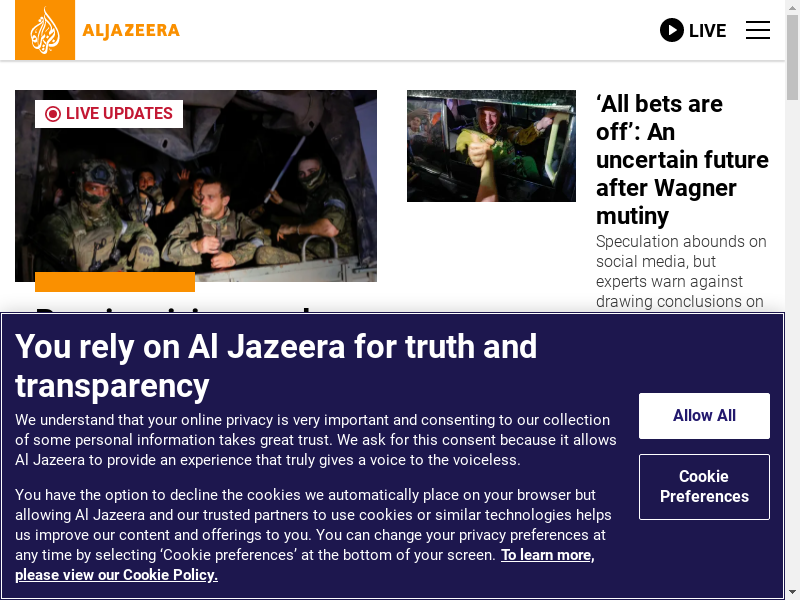

,Unnamed: 0,X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,660.0000,16.500000,66.0000,27.000000,NaN,NaN,NaN,link to live stream video player,NaN
1,1,746.0000,17.500000,24.0000,24.000000,NaN,NaN,NaN,Show navigation menu,NaN
2,2,0.0000,60.000000,785.0000,1030.000000,NaN,NaN,NaN,Featured Content,NaN
3,3,15.0000,1400.000000,493.2500,1830.890625,NaN,NaN,NaN,Content Feed,NaN
4,4,221.6250,1507.468750,80.0000,80.000000,NaN,NaN,play video,Click here to play video,NaN
5,5,35.0000,1953.453125,453.2500,24.000000,NaN,NaN,NaN,opinion,NaN
6,6,553.2500,1430.000000,201.6250,26.000000,NaN,NaN,NaN,most read,NaN
7,7,538.2500,2329.000000,231.6250,384.000000,NaN,NaN,NaN,Newsletter signup Widget,NaN
8,8,554.2500,2522.000000,199.6250,44.000000,NaN,NaN,NaN,E-mail address,NaN
9,9,579.0625,2586.000000,150.0000,44.000000,NaN,NaN,NaN,signup for Week in the Middle East,NaN


In [12]:
describe("https___www_aljazeera_com_")

Issues to address:
 - Where is 'all bets are off'?
 - Can we add an 'z' axis? or if there is any overlay describe only the top overlay?


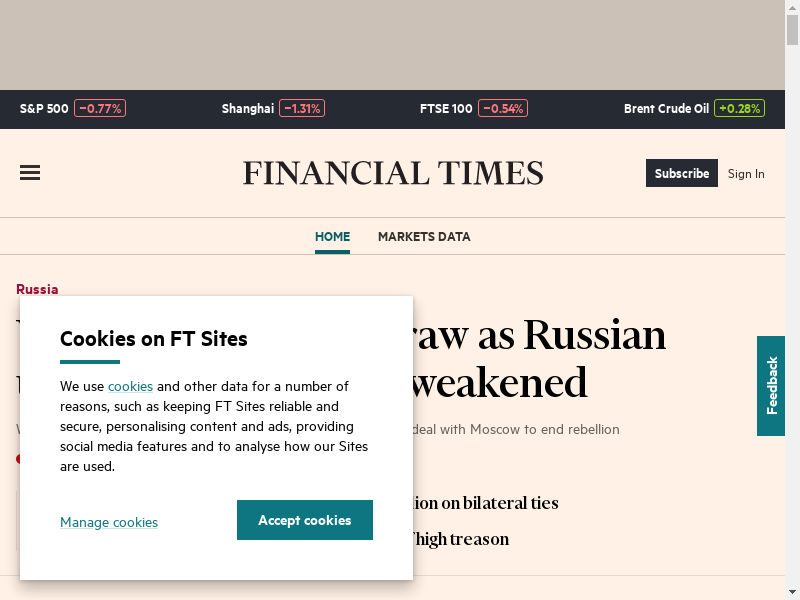

,Unnamed: 0,X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,10.0,153.000000,40,40,NaN,NaN,Open side navigation menu,NaN,NaN
1,1,242.5,161.000000,300,24,NaN,NaN,Go to Financial Times homepage,NaN,NaN
2,2,314.5,218.000000,35,36,NaN,NaN,NaN,Home; current page,NaN
3,3,242.5,-70.500000,300,24,NaN,NaN,Go to Financial Times homepage,NaN,NaN
4,4,80.0,452.000000,83,13,NaN,NaN,June 25 2023 5:30 pm,NaN,NaN
5,5,80.0,2272.125000,82,13,NaN,NaN,June 25 2023 5:06 pm,NaN,NaN
6,6,16.0,7726.453125,69,13,NaN,NaN,June 25 2023 4:20 pm,NaN,NaN
7,7,32.0,17509.687500,213,20,NaN,NaN,Made in Italy Pre-Summit,NaN,NaN
8,8,289.0,17509.687500,207,20,NaN,NaN,FTWeekend Festival,NaN,NaN
9,9,540.0,17509.687500,213,20,NaN,NaN,Moral Money Summit Asia,NaN,NaN


In [13]:
describe("https___www_ft_com_")

Issues:
  - Where is the 'Accept cookies' / 'mangage cookies'?
  - Where is the 'sign in' / 'subscribe'?

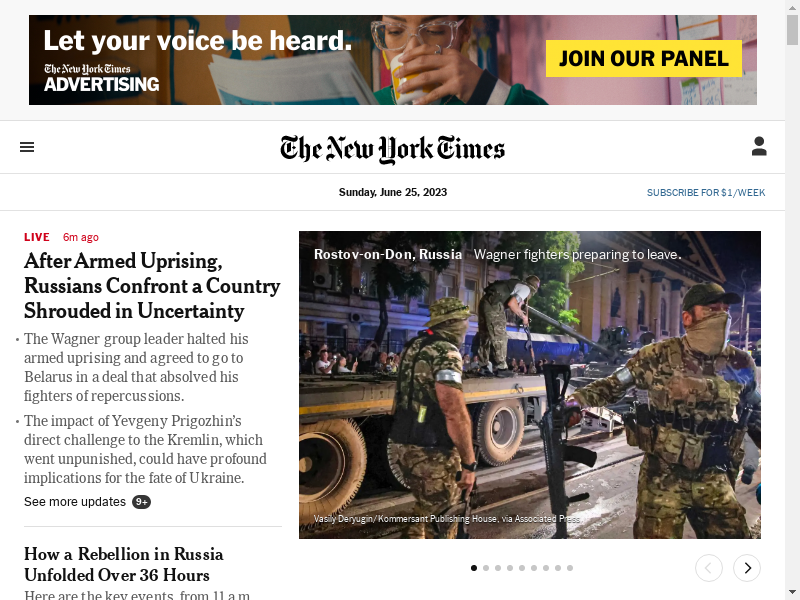

,Unnamed: 0,X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,28.500000,15.000000,728.00000,90.000000,NaN,NaN,3rd party ad content,Advertisement,NaN
1,1,10.000000,131.000000,34.00000,32.000000,NaN,NaN,NaN,Sections Navigation & Search,NaN
2,2,280.000000,135.000000,225.00000,31.000000,NaN,NaN,NaN,New York Times Logo. Click to visit the homepage,NaN
3,3,743.000000,130.000000,32.00000,32.000000,NaN,NaN,NaN,Log in,NaN
4,4,23.546875,-70.000000,737.90625,52.000000,NaN,NaN,NaN,Main,NaN
5,5,131.734375,494.609375,19.18750,13.984375,NaN,NaN,NaN,9 or more more updates available,NaN
6,6,298.859375,231.000000,462.56250,351.359375,NaN,NaN,NaN,Gallery,NaN
7,7,695.421875,554.359375,28.00000,28.000000,NaN,NaN,NaN,previous slide,NaN
8,8,733.421875,554.359375,28.00000,28.000000,NaN,NaN,NaN,next slide,NaN
9,9,242.500000,943.000000,300.00000,250.000000,NaN,NaN,3rd party ad content,Advertisement,NaN


In [14]:
describe("https___www_nytimes_com_")

Issues:
  - Where is the text on the left of the screen?